# Text entailment using BERT model

Fine tunning helper resources: 
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://huggingface.co/docs/transformers/training

In [261]:
import os
import torch
import random
import wget
import zipfile
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [262]:
MODEL_VERSION = 1.0
MODEL_PATH = f'./saved_model/{MODEL_VERSION}'
MODEL_HISTORY_PATH = f'{MODEL_PATH}/history.csv'

DATASET_URL = 'https://nlp.stanford.edu/projects/snli/snli_1.0.zip'
DATASET_DIR_PATH = './data'
DATASET_NAME = 'snli_1.0'
DATASET_DOWNLOAD_PATH = f'{DATASET_DIR_PATH}/{DATASET_NAME}.zip'
DATA_DEV = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_dev.txt'
DATA_TEST = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_test.txt'
DATA_TRAIN = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_train.txt'
DATA_TOKENIZE_DEV = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_dev_.pkl'
DATA_TOKENIZE_TEST = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_test.pkl'
DATA_TOKENIZE_TRAIN = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_train.pkl'

BATCH_SIZE = 50

LABELS = {'neutral': 0, 'contradiction': 1, 'entailment': 2}

In [195]:
if not os.path.isdir(DATASET_DIR_PATH):
    os.mkdir(DATASET_DIR_PATH)
    wget.download(DATASET_URL, out=DATASET_DOWNLOAD_PATH)
    
    with zipfile.ZipFile(DATASET_DOWNLOAD_PATH, 'r') as z:
        z.extractall(DATASET_DIR_PATH)
        os.remove(DATASET_DOWNLOAD_PATH)


In [196]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [197]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [308]:
if not os.path.isfile(DATA_TOKENIZE_TRAIN) and not os.path.isfile(DATA_TOKENIZE_DEV) and not os.path.isfile(DATA_TOKENIZE_TEST):
        
    # Load the base dataset
    def load_and_preprocessing(csv_file: str):
        data = pd.read_csv(csv_file, sep='\t')
        data = data[['gold_label', 'sentence1', 'sentence2']]
        data = data[data['gold_label'] != '-']
        data.dropna(inplace=True)

        data['sentence'] = '[CLS]' + data['sentence1'] + '[SEP]' + data['sentence2'] + '[SEP]'
        data['tokens'] = data['sentence'].apply(tokenizer.tokenize)
        data['gold_label_int'] = data['gold_label'].apply(lambda l: LABELS[l])

        return data

    train = load_and_preprocessing(csv_file=DATA_TRAIN)
    dev = load_and_preprocessing(csv_file=DATA_DEV)
    test = load_and_preprocessing(csv_file=DATA_TEST)

    # Find the max length 
    # +3 is for [SEP] [SEP] [CLS]
    max_len = len(max([max(df['tokens'], key=len) for df in [train, dev, test]], key=len)) + 3
    print(f'max len: {max_len}')

    def encode_process(data: pd.DataFrame):
        def encode(sentence: str, max_len: int):
            return tokenizer.encode_plus(
                sentence,
                return_tensors='pt',
                add_special_tokens=True,
                return_attention_mask=True,
                padding='max_length',
                max_length=max_len,
            )

        data['token_encoded'] = data['sentence'].apply(lambda sen: encode(sen, max_len))
        data[['input_ids', 'token_type_ids', 'attention_mask']] = data['token_encoded'].apply(pd.Series)
        data.drop(['token_encoded', 'tokens'], axis=1, inplace=True)

    encode_process(train)
    train.to_pickle(DATA_TOKENIZE_TRAIN)

    encode_process(dev)
    dev.to_pickle(DATA_TOKENIZE_DEV)

    encode_process(test)
    test.to_pickle(DATA_TOKENIZE_TEST)

else:   
    print('The dataset already tokenized')
    
train = pd.read_pickle(DATA_TOKENIZE_TRAIN)
dev = pd.read_pickle(DATA_TOKENIZE_DEV)
test = pd.read_pickle(DATA_TOKENIZE_TEST)

The dataset already tokenized


In [294]:
def create_tensor_dataset(dataset: pd.DataFrame):
    input_ids = torch.cat(tuple(dataset['input_ids'].values))
    attention_mask = torch.cat(tuple(dataset['attention_mask'].values))
    labels = torch.tensor(dataset['gold_label_int'].values)

    return TensorDataset(input_ids, attention_mask, labels)

In [295]:
train_tensor = create_tensor_dataset(train)
dev_tensor = create_tensor_dataset(dev)
test_tensor = create_tensor_dataset(test)


In [296]:
train_loader = DataLoader(train_tensor, batch_size=BATCH_SIZE, sampler=RandomSampler(train_tensor))
dev_loader = DataLoader(dev_tensor, batch_size=BATCH_SIZE, sampler=SequentialSampler(dev_tensor))
test_loader = DataLoader(test_tensor, batch_size=BATCH_SIZE)

In [297]:
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3, output_attentions=False, output_hidden_states=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [298]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [299]:
max_epoch = 3

In [300]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [301]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [302]:
if not os.path.isdir(MODEL_PATH):

    history = []

    for epoch in range(max_epoch):
        print(f'Epoch {epoch + 1}/{max_epoch}')

        # Training
        train_bar = tqdm(total=len(train_loader), position=1, desc="Training")
        
        total_train_loss = 0

        model.train()  

        for batch in train_loader:
            # squeeze fix the tensor dimenssion
            batch_ids = batch[0].squeeze(1).to(device)
            batch_masks = batch[1].squeeze(1).to(device)
            batch_labels = batch[2].to(device)

            model.zero_grad()

            output = model(batch_ids, token_type_ids = None, attention_mask = batch_masks, labels = batch_labels)
            loss = output.loss

            total_train_loss += loss.item()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            train_bar.update(1)
            train_bar.set_postfix({'loss': total_train_loss / len(train_loader)})

        avg_train_loss = total_train_loss / len(train_loader)
        
        # Evaluation
        eval_bar = tqdm(total=len(dev_loader), position=0, desc="Validation")
        
        total_eval_loss = 0
        total_eval_accuracy = 0

        model.eval()

        for batch in dev_loader:
            batch_ids = batch[0].squeeze(1).to(device)
            batch_masks = batch[1].squeeze(1).to(device)
            batch_labels = batch[2].to(device)

            with torch.no_grad():
                output = model(batch_ids, token_type_ids = None, attention_mask = batch_masks, labels = batch_labels)
        
            total_eval_loss += output.loss.item()
            
            # Accumulate the accuracy
            logits = output.logits.numpy()
            logits_labels = np.argmax(logits, axis=1)
            accuracy = np.sum(logits_labels == batch_labels.numpy()) / len(batch_labels)
            total_eval_accuracy += accuracy

            eval_bar.update(1)
            eval_bar.set_postfix({'loss': total_train_loss / len(train_loader), 'acc': total_eval_accuracy / len(dev_loader)})

        avg_eval_loss = total_eval_loss / len(dev_loader)
        avg_eval_accuracy = total_eval_accuracy / len(dev_loader)

        history.append({
            'epoch': epoch,
            'training_loss': avg_train_loss,
            'validation_loss': avg_eval_loss,
            'validation_accuracy': avg_eval_accuracy
        })

        # Save every epoch
        model.save_pretrained(MODEL_PATH)
        pd.DataFrame(history).set_index('epoch').to_csv(MODEL_HISTORY_PATH)

else:
    print(f'Model version {MODEL_VERSION} already exists')

Epoch 1/3


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/3


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/3


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

In [303]:
history = pd.read_csv(MODEL_HISTORY_PATH)
history

,epoch,training_loss,validation_loss,validation_accuracy
0,0,1.171065,1.172204,0.343673
1,1,1.143826,1.139167,0.333469
2,2,1.106954,1.133112,0.333061


In [304]:
l_model = BertForSequenceClassification.from_pretrained(MODEL_PATH)

In [305]:
# Accuracy
l_model.eval()

prediction, true_labeles = [], []
test_bar = tqdm(total=len(test_loader), desc="Testing")

for batch in test_loader:
    batch_ids = batch[0].squeeze(1).to(device)
    batch_masks = batch[1].squeeze(1).to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():
        output = l_model(batch_ids, token_type_ids = None, attention_mask = batch_masks)

    logits = output.logits
    prediction.append(np.argmax(logits.numpy(), axis=1))
    true_labeles.append(batch_labels.numpy())

    test_bar.update(1)

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

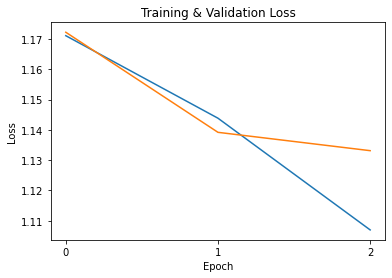

In [306]:
plt.plot(history['training_loss'], label='Training')
plt.plot(history['validation_loss'], label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(max_epoch))
plt.ylabel('Loss')
plt.show()

### Classification Report

In [307]:
all_prediction = np.concatenate(prediction)
all_true_labels = np.concatenate(true_labeles)

print(classification_report(all_prediction, all_true_labels, labels=np.unique(all_true_labels), zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.32      0.48        90
           1       0.00      0.00      0.00         0
           2       0.11      0.44      0.18         9

    accuracy                           0.33        99
   macro avg       0.35      0.26      0.22        99
weighted avg       0.86      0.33      0.45        99

